In [179]:
from synthetic_data import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from get_real_data import *

from preprocessing import preprocess
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Masking, Conv1D, Flatten, MaxPooling1D, Input, Concatenate, Dropout, AveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop


In [130]:
X1, y1, X2, y2, X3, y3, X4, y4 = get_real_X_y(noise=False)
X1a, y1a, X2a, y2a, X3a, y3a, X4a, y4a = augmentation(X1, y1, X2, y2, X3, y3, X4, y4, noise=False)

X_ris_wedg, y_ris_wedg, X_fal_wedg, y_fal_wedg, X_d_top, y_d_top, X_d_bottom, y_d_bottom = get_X_y(noise=False, general=False)
X_ris_wedga, y_ris_wedga, X_fal_wedga, y_fal_wedga, X_d_topa, y_d_topa, X_d_bottoma, y_d_bottoma = augmentation(X_ris_wedg, y_ris_wedg, X_fal_wedg, y_fal_wedg, X_d_top, y_d_top, X_d_bottom, y_d_bottom, noise=False)

X_ris_wedg = X1a + X_ris_wedga
y_ris_wedg = y1a + y_ris_wedga

X_train_ris, y_train_p_ris, y_train_dates_ris, X_test_ris, y_test_p_ris, y_test_dates_ris = preprocess(X_ris_wedg, y_ris_wedg)

X_fal_wedg = X2a + X_fal_wedga
y_fal_wedg = y2a + y_fal_wedga

X_train_fal, y_train_p_fal, y_train_dates_fal, X_test_fal, y_test_p_fal, y_test_dates_fal = preprocess(X_fal_wedg, y_fal_wedg)

X_d_top = X3a + X_d_topa
y_d_top = y3a + y_d_topa

X_train_dt, y_train_p_dt, y_train_dates_dt, X_test_dt, y_test_p_dt, y_test_dates_dt = preprocess(X_d_top, y_d_top)

X_d_bottom = X4a + X_d_bottoma
y_d_bottom = y4a + y_d_bottoma

X_train_db, y_train_p_db, y_train_dates_db, X_test_db, y_test_p_db, y_test_dates_db = preprocess(X_d_bottom, y_d_bottom)

X_full = X_ris_wedg + X_fal_wedg + X_d_top + X_d_bottom
y_full = y_ris_wedg + y_fal_wedg + y_d_top + y_d_bottom
X_train_full, y_train_p_full, y_train_dates_full, X_test_full, y_test_p_full, y_test_dates_full = preprocess(X_full, y_full)


In [107]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* higher level == Asses general trend 
* intermediate levels == Asses specific trend 
* lower level == Asses dates 

* descending triangle, falling wedge, downtrend, descending channel 
* ascending triangle, rising wedge, uptrend, vertical run up
* double bottom, hs bottom, support
* double top, hs top, resistance

* Tryout without synthetic data, improve the data if needed

In [2]:
X_ris_wedg, y_ris_wedg, X_fal_wedg, y_fal_wedg, X_d_top, y_d_top, X_d_bottom, y_d_bottom = get_X_y(noise=False, general=True)

In [3]:
X_rw_noise, y_rw_noise, X_fw_noise, y_fw_noise, X_dt_noise, y_dt_noise, X_db_noise, y_db_noise = get_hack_noise(X_ris_wedg, y_ris_wedg, X_fal_wedg, y_fal_wedg, X_d_top, y_d_top, X_d_bottom, y_d_bottom, synth=True, real=True, f=True)

In [4]:
X_synth = X_ris_wedg + X_rw_noise + X_fal_wedg + X_fw_noise + X_d_top + X_dt_noise + X_d_bottom + X_db_noise
y_synth = y_ris_wedg + y_rw_noise + y_fal_wedg + y_fw_noise + y_d_top + y_dt_noise + y_d_bottom + y_db_noise

In [5]:
X1, y1, X2, y2, X3, y3, X4, y4 = get_real_X_y(noise=False)

In [6]:
X1_noise, y1_noise, X2_noise, y2_noise, X3_noise, y3_noise, X4_noise, y4_noise = get_hack_noise(X1, y1, X2, y2, X3, y3, X4, y4, synth=False, real=True, f=False)

In [7]:
X_up, y_up, X_down, y_down = get_up_down(patterns=["uptrend","downtrend"])

In [8]:
X_real = X1 + X1_noise + X2 + X2_noise + X3 + X3_noise + X4 + X4_noise + X_up + X_down
y_real = y1 + y1_noise + y2 + y2_noise + y3 + y3_noise + y4 + y4_noise + y_up + y_down


In [9]:
X = X_real + X_synth
y = y_real + y_synth

In [10]:
X_train_preprocessed, y_train_p, y_train_dates, X_test_preprocessed, y_test_p, y_test_dates = preprocess(X_synth, y_synth)

2023-09-04 12:36:38.836836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-04 12:36:38.838719: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


* get real data
* data separation in 3 windows 2 with no pattern 
    the one with pattern give it slack in both sides and make it 10 times with that slack
* flip the data upside down and give it the opposite name

X1 = np.array(X1)
X2 = np.array(X2)
X3 = np.array(X3)
X4 = np.array(X4)
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)


In [162]:
X1, y1, X2, y2, X3, y3, X4, y4 = get_real_X_y(noise=False)


In [163]:
X1a, y1a, X2a, y2a, X3a, y3a, X4a, y4a = augmentation(X1, y1, X2, y2, X3, y3, X4, y4, noise=True)

In [164]:
Xa = X1a + X2a +X3a + X4a
ya = y1a + y2a +y3a + y4a

In [166]:
X_train_a, y_train_p_a, y_train_dates_a, X_test_a, y_test_p_a, y_test_dates_a = preprocess(Xa, ya)

In [ ]:
X_ris_wedg, y_ris_wedg, X_fal_wedg, y_fal_wedg, X_d_top, y_d_top, X_d_bottom, y_d_bottom = get_X_y(noise=False, general=False)

In [108]:
X_ris_wedga, y_ris_wedga, X_fal_wedga, y_fal_wedga, X_d_topa, y_d_topa, X_d_bottoma, y_d_bottoma = augmentation(X_ris_wedg, y_ris_wedg, X_fal_wedg, y_fal_wedg, X_d_top, y_d_top, X_d_bottom, y_d_bottom, noise=True)

In [96]:
len(x_1), len(y_1)

(1112, 1112)

In [109]:
X_syntha = X_ris_wedga + X_fal_wedga + X_d_topa + X_d_bottoma
y_syntha = y_ris_wedga + y_fal_wedga + y_d_topa + y_d_bottoma

In [110]:
X_c = Xa + X_syntha
y_c = ya + y_syntha

In [111]:
len(X_c), len(Xa)

(46857, 34428)

In [112]:
a=[]
for i in range(len(Xa)):
    a.append(len(Xa[i]))

In [113]:
min(a)

2

In [114]:
X_train_c, y_train_p_c, y_train_dates_c, X_test_c, y_test_p_c, y_test_dates_c = preprocess(X_c, y_c)

In [116]:
len(X_train_a), len(X_train_c)

(27542, 37485)

### We have to change with the functional api, because is a two problem one for regresion and other for classification

### We have to add an intermediate layer

### Look into generative models

In [254]:
def initialize_model_CNN():
       
    # Input layer
    input_shape = X_train_preprocessed.shape[1:]
    input_layer = Input(shape=input_shape)

    # Shared layers
    masked_input = Masking(mask_value=-1)(input_layer)
    conv1d_1 = Conv1D(32, activation='relu', kernel_size=3, kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3))(masked_input)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv1d_1)
    conv1d_2 = Conv1D(32, activation='relu', kernel_size=3)(maxpool_1)
    flatten = Flatten()(conv1d_2)
    dense_1 = Dense(units=200, activation='relu')(flatten)
    dense_2 = Dense(units=100, activation='relu')(dense_1)
    dense_3 = Dense(units=16, activation='relu')(dense_2)
    dense_4 = Dense(units=16, activation='relu')(dense_3)

    # Classification output
    classification_output = Dense(units=4, activation='softmax', name='classification_output')(dense_4)

    # Regression output
    regression_output = Dense(units=2, activation='linear', name='regression_output')(dense_4)

    # Create the model
    model = Model(inputs=input_layer, outputs=[classification_output, regression_output])

    # Compile the model with appropriate loss functions and metrics for each output
    model.compile(optimizer='adam',
                loss={'classification_output': 'categorical_crossentropy', 'regression_output': 'mean_squared_error'},
                metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})


    
    return model

In [255]:

es = EarlyStopping(patience = 10, restore_best_weights=True)

model = initialize_model_CNN()

history = model.fit(
    x=X_train_preprocessed,
    y={'classification_output': y_train_p, 'regression_output': y_train_dates},
    validation_split = 0.2,
    shuffle = True,
    batch_size=32,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

Epoch 1/50
122/122 [==============================] - 2s 13ms/step - loss: 26394.1973 - classification_output_loss: 16.2295 - regression_output_loss: 26377.9102 - classification_output_accuracy: 0.2524 - regression_output_mae: 127.7590 - val_loss: 22432.6191 - val_classification_output_loss: 7.9806 - val_regression_output_loss: 22424.5859 - val_classification_output_accuracy: 0.3897 - val_regression_output_mae: 118.1439
Epoch 2/50
122/122 [==============================] - 1s 12ms/step - loss: 20004.3984 - classification_output_loss: 2.7402 - regression_output_loss: 20001.6113 - classification_output_accuracy: 0.2513 - regression_output_mae: 116.2460 - val_loss: 21259.2988 - val_classification_output_loss: 1.2112 - val_regression_output_loss: 21258.0293 - val_classification_output_accuracy: 0.1662 - val_regression_output_mae: 124.1331
Epoch 3/50
122/122 [==============================] - 1s 11ms/step - loss: 19963.3262 - classification_output_loss: 1.1645 - regression_output_loss: 1996

In [256]:
evaluation = model.evaluate(
    x=X_test_preprocessed,  # Test input data
    y={'classification_output': y_test_p, 'regression_output': y_test_dates},  # Dictionary of test labels
    verbose=1  # Set to 1 for progress updates during evaluation
)
evaluation

39/39 [==============================] - 0s 4ms/step - loss: 19809.3594 - classification_output_loss: 1.2170 - regression_output_loss: 19808.0898 - classification_output_accuracy: 0.1649 - regression_output_mae: 117.8358


[19809.359375,
 1.2170205116271973,
 19808.08984375,
 0.16488924622535706,
 117.8358383178711]

In [257]:
def plot_clas_reg(val_clas="val_classification_output_accuracy", val_mae="val_regression_output_mae"):
    clas = history.history[val_clas]
    reg = history.history[val_mae]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Horizontally stacked subplots')
    ax1.plot(clas)
    ax2.plot(reg)

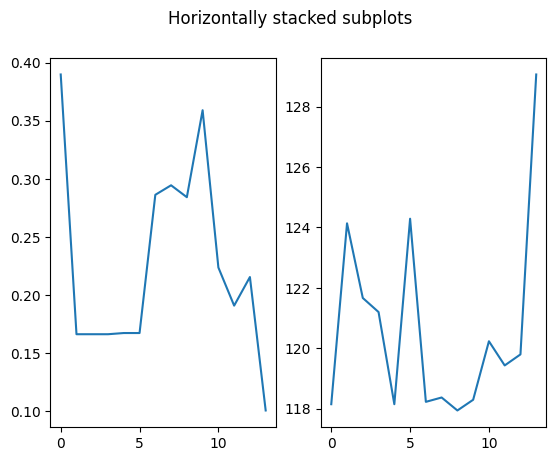

In [258]:
plot_clas_reg()

#### Model with the classification target as an intermediate layer

In [161]:
def two_layer_model():
    
    # Input layer
    input_shape = X_train_preprocessed.shape[1:]
    input_layer = Input(shape=input_shape)

    # Shared layers
    masked_input = Masking(mask_value=-1)(input_layer)
    conv1d_1 = Conv1D(32, activation='relu', kernel_size=3, kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3))(masked_input)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv1d_1)
    conv1d_2 = Conv1D(32, activation='relu', kernel_size=3)(maxpool_1)
    flatten = Flatten()(conv1d_2)
    dense_1 = Dense(units=200, activation='relu')(flatten)
    dense_2 = Dense(units=100, activation='relu')(dense_1)
    dense_3 = Dense(units=16, activation='relu')(dense_2)
    dense_4 = Dense(units=16, activation='relu')(dense_3)

    # Classification output
    classification_output = Dense(units=5, activation='softmax', name='classification_output')(dense_4)

    
    # Regression output
    regression_output = Dense(units=2, activation='linear', name='regression_output')(dense_4)

    # Create the combined model with classification as an intermediate output
    combined_model = Model(inputs=input_layer, outputs=[classification_output, regression_output])

    # Compile the combined model
    combined_model.compile(optimizer='adam',
                        loss={'classification_output': 'categorical_crossentropy', 'regression_output': 'mean_squared_error'},
                        metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})

    return combined_model


In [162]:
es = EarlyStopping(patience = 10, restore_best_weights=True)

model_1 = two_layer_model()

history = model_1.fit(
    x=X_train_preprocessed,
    y={'classification_output': y_train_p, 'regression_output': y_train_dates},
    validation_split = 0.2,
    shuffle = True,
    batch_size=32,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

Epoch 1/50
122/122 [==============================] - 3s 17ms/step - loss: 22406.8086 - classification_output_loss: 25.3569 - regression_output_loss: 22381.3926 - classification_output_accuracy: 0.1611 - regression_output_mae: 121.0195 - val_loss: 20490.5312 - val_classification_output_loss: 4.0698 - val_regression_output_loss: 20486.4082 - val_classification_output_accuracy: 0.5323 - val_regression_output_mae: 118.8594
Epoch 2/50
122/122 [==============================] - 2s 18ms/step - loss: 20776.6660 - classification_output_loss: 2.7126 - regression_output_loss: 20773.8984 - classification_output_accuracy: 0.2411 - regression_output_mae: 117.4091 - val_loss: 22056.1328 - val_classification_output_loss: 2.1658 - val_regression_output_loss: 22053.9121 - val_classification_output_accuracy: 0.1303 - val_regression_output_mae: 118.1427
Epoch 3/50
122/122 [==============================] - 2s 17ms/step - loss: 19605.1426 - classification_output_loss: 1.9613 - regression_output_loss: 1960

In [261]:
evaluation_1 = model_1.evaluate(
    x=X_test_preprocessed,  # Test input data
    y={'classification_output': y_test_p, 'regression_output': y_test_dates},  # Dictionary of test labels
    verbose=1  # Set to 1 for progress updates during evaluation
)
evaluation_1

39/39 [==============================] - 0s 5ms/step - loss: 27582.5430 - classification_output_loss: 4.0243 - regression_output_loss: 27578.4648 - classification_output_accuracy: 0.6325 - regression_output_mae: 124.7620


[27582.54296875,
 4.024256706237793,
 27578.46484375,
 0.6324856281280518,
 124.761962890625]

#### Conditional intermediate layer

In [289]:
def conditional_regression_model():
    # Input layer
    # Input layer
    input_shape = X_train_preprocessed.shape[1:]
    input_layer = Input(shape=input_shape)


    # Shared layers
    masked_input = Masking(mask_value=-1)(input_layer)
    conv1d_1 = Conv1D(32, activation='relu', kernel_size=3, kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3))(masked_input)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv1d_1)
    conv1d_2 = Conv1D(32, activation='relu', kernel_size=3)(maxpool_1)
    flatten = Flatten()(conv1d_2)
    dense_1 = Dense(units=200, activation='relu')(flatten)
    dropout_1 = Dropout(rate=0.5)(dense_1)
    dense_2 = Dense(units=128, activation='relu')(dropout_1)
    dropout_2 = Dropout(rate=0.5)(dense_2)
    dense_3 = Dense(units=64, activation='relu')(dropout_2)
    dropout_3 = Dropout(rate=0.5)(dense_3)
    dense_4 = Dense(units=32, activation='relu')(dense_3)

    # Classification output
    classification_output = Dense(units=4, activation='softmax', name='classification_output')(dense_4)

    # Combine input and classification output for regression
    regression_input = Concatenate()([dense_4, classification_output])

    # Regression output
    regression_output = Dense(units=2, activation='linear', name='regression_output')(regression_input)

    # Create the combined model
    model = Model(inputs=input_layer, outputs=[classification_output, regression_output])

    # Compile the model with appropriate loss functions and metrics for each output
    model.compile(optimizer='adam',
                  loss={'classification_output': 'categorical_crossentropy', 'regression_output': 'mean_squared_error'},
                  metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})

    return model


In [290]:
es = EarlyStopping(patience = 10, restore_best_weights=True)

model_2 = conditional_regression_model()

history = model_2.fit(
    x=X_train_preprocessed,
    y={'classification_output': y_train_p, 'regression_output': y_train_dates},
    validation_split = 0.2,
    shuffle = True,
    batch_size=32,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

Epoch 1/50
122/122 [==============================] - 3s 15ms/step - loss: 25791.9531 - classification_output_loss: 38.7561 - regression_output_loss: 25753.1406 - classification_output_accuracy: 0.1980 - regression_output_mae: 126.4139 - val_loss: 22091.2949 - val_classification_output_loss: 9.5588 - val_regression_output_loss: 22081.6836 - val_classification_output_accuracy: 0.6308 - val_regression_output_mae: 118.7389
Epoch 2/50
122/122 [==============================] - 2s 12ms/step - loss: 21190.7090 - classification_output_loss: 7.3136 - regression_output_loss: 21183.3438 - classification_output_accuracy: 0.2437 - regression_output_mae: 118.6788 - val_loss: 21341.3379 - val_classification_output_loss: 3.6788 - val_regression_output_loss: 21337.6094 - val_classification_output_accuracy: 0.6308 - val_regression_output_mae: 118.2330
Epoch 3/50
122/122 [==============================] - 1s 11ms/step - loss: 20639.3457 - classification_output_loss: 5.6867 - regression_output_loss: 2063

In [291]:
evaluation_2 = model_2.evaluate(
    x=X_test_preprocessed,  # Test input data
    y={'classification_output': y_test_p, 'regression_output': y_test_dates},  # Dictionary of test labels
    verbose=1  # Set to 1 for progress updates during evaluation
)


 1/39 [..............................] - ETA: 0s - loss: 23163.3613 - classification_output_loss: 5.2839 - regression_output_loss: 23158.0273 - classification_output_accuracy: 0.1875 - regression_output_mae: 138.2546

39/39 [==============================] - 0s 5ms/step - loss: 19497.1348 - classification_output_loss: 2.6900 - regression_output_loss: 19494.3887 - classification_output_accuracy: 0.1649 - regression_output_mae: 114.4255


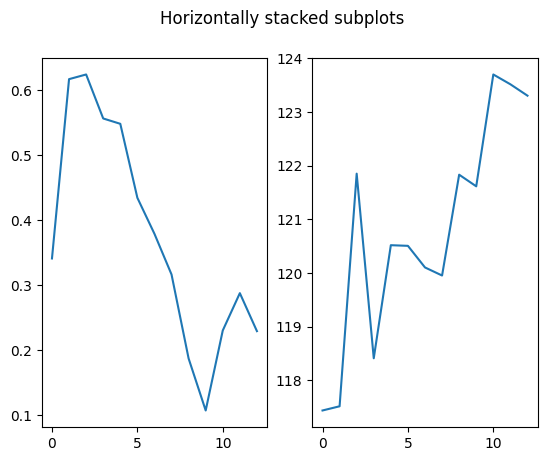

In [175]:
plot_clas_reg()

#### Finding better parameters for the neural network

In [44]:
def conditional_regression_model_1():
    # Input layer
    # Input layer
    input_shape = X_train_preprocessed.shape[1:]
    input_layer = Input(shape=input_shape)


    # Shared layers
    masked_input = Masking(mask_value=-1)(input_layer)
    conv1d_1 = Conv1D(32, activation='relu', kernel_size=3, kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3))(masked_input)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv1d_1)
    conv1d_2 = Conv1D(32, activation='relu', kernel_size=3)(maxpool_1)
    
    flatten = Flatten()(conv1d_2)
    dense_1 = Dense(units=192, activation='relu')(flatten)
    dropout_1 = Dropout(rate=0.5)(dense_1)
    dense_2 = Dense(units=128, activation='relu')(dropout_1)
    dropout_2 = Dropout(rate=0.5)(dense_2)
    dense_3 = Dense(units=64, activation='relu')(dropout_2)
    dropout_3 = Dropout(rate=0.5)(dense_3)
    dense_4 = Dense(units=32, activation='relu')(dropout_3)
    

    # Classification output
    classification_output = Dense(units=4, activation='softmax', name='classification_output')(dense_4)

    # Combine input and classification output for regression
    regression_input = Concatenate()([dense_4, classification_output])

    # Regression output
    regression_output = Dense(units=2, activation='linear', name='regression_output')(regression_input)

    # Create the combined model
    model = Model(inputs=input_layer, outputs=[classification_output, regression_output])

    # Compile the model with appropriate loss functions and metrics for each output
    model.compile(optimizer='adam',
                  loss={'classification_output': 'categorical_crossentropy', 'regression_output': 'mean_squared_error'},
                  metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})

    return model


In [45]:
es = EarlyStopping(patience = 10, restore_best_weights=True)
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

model_3 = conditional_regression_model_1()

history = model_3.fit(
    x=X_train_preprocessed,
    y={'classification_output': y_train_p, 'regression_output': y_train_dates},
    validation_split = 0.2,
    shuffle = True,
    batch_size=32,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

Epoch 1/50
122/122 [==============================] - 3s 15ms/step - loss: 17647.1992 - classification_output_loss: 22.4960 - regression_output_loss: 17624.6504 - classification_output_accuracy: 0.1439 - regression_output_mae: 97.3930 - val_loss: 14075.0596 - val_classification_output_loss: 8.5618 - val_regression_output_loss: 14066.4434 - val_classification_output_accuracy: 0.1559 - val_regression_output_mae: 91.2169
Epoch 2/50
122/122 [==============================] - 1s 12ms/step - loss: 10886.1963 - classification_output_loss: 16.0652 - regression_output_loss: 10870.0791 - classification_output_accuracy: 0.2542 - regression_output_mae: 79.3783 - val_loss: 10867.3477 - val_classification_output_loss: 6.1749 - val_regression_output_loss: 10861.1211 - val_classification_output_accuracy: 0.1046 - val_regression_output_mae: 81.3304
Epoch 3/50
122/122 [==============================] - 1s 11ms/step - loss: 10147.5234 - classification_output_loss: 14.6609 - regression_output_loss: 10132.

In [21]:
!pip freeze | grep pydot

pydot==1.4.2


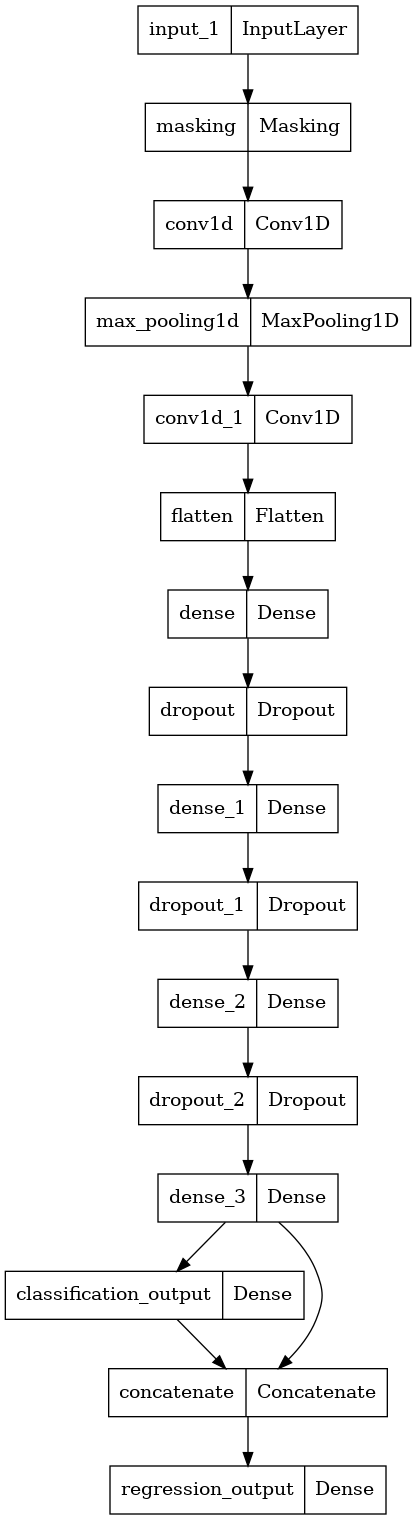

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model_3)

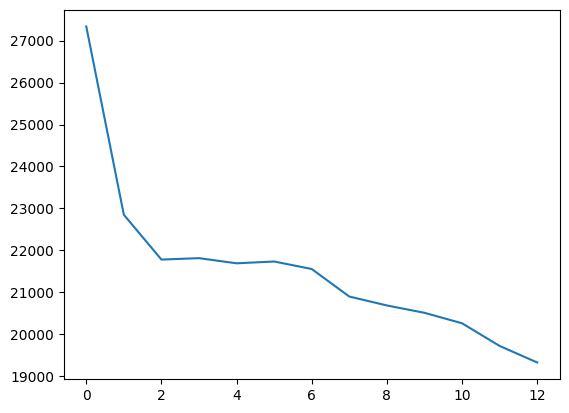

In [297]:
plt.plot(history.history["loss"])

In [42]:
evaluation_3 = model_3.evaluate(
    x=X_test_preprocessed,  # Test input data
    y={'classification_output': y_test_p, 'regression_output': y_test_dates},  # Dictionary of test labels
    verbose=1  # Set to 1 for progress updates during evaluation
)


39/39 [==============================] - 0s 4ms/step - loss: 8526.6074 - classification_output_loss: 7.7822 - regression_output_loss: 8518.7744 - classification_output_accuracy: 0.1214 - regression_output_mae: 70.2954


In [1]:
X_train_synth, y_train_p_synth, y_train_dates_synth, X_test_synth, y_test_p_synth, y_test_dates_synth = preprocess(X_synth, y_synth)

NameError: name 'preprocess' is not defined

In [117]:
def conditional_regression_model_2():
    # Input layer
    # Input layer
    input_shape = X_train_c.shape[1:]
    input_layer = Input(shape=input_shape)


    # Shared layers
    masked_input = Masking(mask_value=-1)(input_layer)
    #conv1d_1 = Conv1D(8, activation='relu', kernel_size=3)(masked_input)
    #maxpool_1 = AveragePooling1D(pool_size=2)(conv1d_1)
    #conv1d_2 = Conv1D(16, activation='relu', kernel_size=5)(maxpool_1)
    #maxpool_2 = AveragePooling1D(pool_size=2)(conv1d_2)
    #conv1d_3 = Conv1D(32, activation='relu', kernel_size=5)(maxpool_2)
    #maxpool_3 = AveragePooling1D(pool_size=2)(conv1d_3)
    #conv1d_4 = Conv1D(64, activation='relu', kernel_size=5)(maxpool_3)
    
    lstm_1 = LSTM(units=16, return_sequences=True)(masked_input)
    # lstm_2 = LSTM(units=8, return_sequences=True)(lstm_1)


    # Add the second LSTM layer
    lstm_3 = LSTM(units=16, return_sequences=False)(lstm_1)

    
    
    flatten = Flatten()(lstm_3)
    dense_1 = Dense(units=32, activation='relu')(flatten)
    #dropout_1 = Dropout(rate=0.5)(dense_1)
    # dense_2 = Dense(units=32, activation='relu')(dense_1)
    
    

    # Classification output
    classification_output = Dense(units=5, activation='softmax', name='classification_output')(dense_1)

    

    # Create the combined model

    
    # Create the combined model
    model = Model(inputs=input_layer, outputs=[classification_output])

    # Compile the model with appropriate loss functions and metrics for each output
    model.compile(optimizer='rmsprop',
                  loss={'classification_output': 'categorical_crossentropy'},
                  metrics={'classification_output': 'accuracy'})

    return model


In [147]:
_,counts = np.unique(y_train_p_c, axis=0, return_counts=True)
max(counts)/sum(counts)

0.24121648659463785

In [118]:
es = EarlyStopping(patience = 10, restore_best_weights=True)
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

model_4 = conditional_regression_model_2()

history = model_4.fit(
    x=X_train_c,
    y={'classification_output': y_train_p_c},
    validation_split = 0.2,
    shuffle = True,
    batch_size=32,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

Epoch 1/50
938/938 [==============================] - 218s 228ms/step - loss: 1.1207 - accuracy: 0.5514 - val_loss: 0.9806 - val_accuracy: 0.6042
Epoch 2/50
938/938 [==============================] - 217s 231ms/step - loss: 0.9415 - accuracy: 0.6386 - val_loss: 0.8937 - val_accuracy: 0.6645
Epoch 3/50
316/938 [=========>....................] - ETA: 2:40 - loss: 0.8829 - accuracy: 0.6741

KeyboardInterrupt: 

In [180]:
def conditional_regression_model_3():
    # Input layer
    # Input layer
    input_shape = X_train_a.shape[1:]
    input_layer = Input(shape=input_shape)


    # Shared layers
    masked_input = Masking(mask_value=-1)(input_layer)
    #conv1d_1 = Conv1D(8, activation='relu', kernel_size=3)(masked_input)
    # maxpool_1 = AveragePooling1D(pool_size=2)(conv1d_1)
    # conv1d_2 = Conv1D(16, activation='relu', kernel_size=5)(maxpool_1)
    #maxpool_2 = AveragePooling1D(pool_size=2)(conv1d_2)
    #conv1d_3 = Conv1D(32, activation='relu', kernel_size=5)(maxpool_2)
    #maxpool_3 = AveragePooling1D(pool_size=2)(conv1d_3)
    #conv1d_4 = Conv1D(64, activation='relu', kernel_size=5)(maxpool_3)
    
    lstm_1 = LSTM(units=16, return_sequences=True)(masked_input)
    #lstm_2 = LSTM(units=8, return_sequences=True)(lstm_1)


    # Add the second LSTM layer
    lstm_3 = LSTM(units=16, return_sequences=False)(lstm_1)

    flatten = Flatten()(lstm_3)
    dense_1 = Dense(units=32, activation='relu')(flatten)
    #dropout_1 = Dropout(rate=0.5)(dense_1)
    # dense_2 = Dense(units=32, activation='relu')(dense_1)
    
    # Classification output
    classification_output = Dense(units=5, activation='softmax', name='classification_output')(dense_1)

    # Combine input and classification output for regression
    regression_input = Concatenate()([dense_1, classification_output])

    # Regression output
    regression_output = Dense(units=2, activation='linear', name='regression_output')(regression_input)

    # Create the combined model
    model = Model(inputs=input_layer, outputs=[classification_output, regression_output])

    # Compile the model with appropriate loss functions and metrics for each output
    model.compile(optimizer=RMSprop(learning_rate=0.005),
                  loss={'classification_output': 'categorical_crossentropy', 'regression_output': 'mean_squared_error'},
                  loss_weights={'classification_output': 1000, 'regression_output': 1},
                  metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})

    return model

    


In [181]:
es = EarlyStopping(patience = 10, restore_best_weights=True)
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

model_5 = conditional_regression_model_3()


history = model_5.fit(
    x=X_train_a,
    y={'classification_output': y_train_p_a, 'regression_output': y_train_dates_a},
    validation_split = 0.2,
    shuffle = True,
    batch_size=32,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

Epoch 1/50
689/689 [==============================] - 139s 178ms/step - loss: 7831.8159 - classification_output_loss: 1.3348 - regression_output_loss: 6497.0020 - classification_output_accuracy: 0.4565 - regression_output_mae: 49.8176 - val_loss: 5407.5815 - val_classification_output_loss: 1.1312 - val_regression_output_loss: 4276.4043 - val_classification_output_accuracy: 0.5179 - val_regression_output_mae: 40.9679
Epoch 2/50
689/689 [==============================] - 120s 174ms/step - loss: 4361.7144 - classification_output_loss: 1.0743 - regression_output_loss: 3287.4170 - classification_output_accuracy: 0.5713 - regression_output_mae: 37.0263 - val_loss: 4143.0591 - val_classification_output_loss: 0.9794 - val_regression_output_loss: 3163.6677 - val_classification_output_accuracy: 0.6074 - val_regression_output_mae: 36.3431
Epoch 3/50
689/689 [==============================] - 123s 178ms/step - loss: 3836.1077 - classification_output_loss: 0.8631 - regression_output_loss: 2972.9939

KeyboardInterrupt: 

In [ ]:
def conditional_regression_model_3():
    # Input layer
    # Input layer
    input_shape = X_train_a.shape[1:]
    input_layer = Input(shape=input_shape)


    # Shared layers
    masked_input = Masking(mask_value=-1)(input_layer)
    #conv1d_1 = Conv1D(8, activation='relu', kernel_size=3)(masked_input)
    # maxpool_1 = AveragePooling1D(pool_size=2)(conv1d_1)
    # conv1d_2 = Conv1D(16, activation='relu', kernel_size=5)(maxpool_1)
    #maxpool_2 = AveragePooling1D(pool_size=2)(conv1d_2)
    #conv1d_3 = Conv1D(32, activation='relu', kernel_size=5)(maxpool_2)
    #maxpool_3 = AveragePooling1D(pool_size=2)(conv1d_3)
    #conv1d_4 = Conv1D(64, activation='relu', kernel_size=5)(maxpool_3)
    
    lstm_1 = LSTM(units=16, return_sequences=True)(masked_input)
    #lstm_2 = LSTM(units=8, return_sequences=True)(lstm_1)


    # Add the second LSTM layer
    lstm_3 = LSTM(units=16, return_sequences=False)(lstm_1)

    flatten = Flatten()(lstm_3)
    dense_1 = Dense(units=32, activation='relu')(flatten)
    #dropout_1 = Dropout(rate=0.5)(dense_1)
    # dense_2 = Dense(units=32, activation='relu')(dense_1)
    
    # Classification output
    classification_output = Dense(units=5, activation='softmax', name='classification_output')(dense_1)

    # Combine input and classification output for regression
    regression_input = Concatenate()([dense_1, classification_output])

    # Regression output
    regression_output = Dense(units=2, activation='linear', name='regression_output')(regression_input)

    # Create the combined model
    model = Model(inputs=input_layer, outputs=[classification_output, regression_output])

    # Compile the model with appropriate loss functions and metrics for each output
    model.compile(optimizer='rmsprop',
                  loss={'classification_output': 'categorical_crossentropy', 'regression_output': 'mean_squared_error'},
                  loss_weights={'classification_output': 1000, 'regression_output': 1},
                  metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})

    return model

    


In [ ]:
classification_output_accuracy: 0.2452 - regression_output_mae: 32.7040 - val_loss: 1628.4587 - val_classification_output_loss: 1.5401 - val_regression_output_loss: 1626.9191 - val_classification_output_accuracy: 0.2970 - val_regression_output_mae: 18.8227
Epoch 2/50
689/689 [==============================] - 95s 138ms/step - loss: 1266.1523 - classification_output_loss: 1.5275 - regression_output_loss: 1264.6252 - classification_output_accuracy: 0.3475 - regression_output_mae: 16.8986 - val_loss: 1122.8607 - val_classification_output_loss: 1.5062 - val_regression_output_loss: 1121.3544 - val_classification_output_accuracy: 0.3581 - val_regression_output_mae: 15.4361
Epoch 3/50
689/689 [==============================] - 85s 123ms/step - loss: 1097.8303 - classification_output_loss: 1.4866 - regression_output_loss: 1096.3440 - classification_output_accuracy: 0.3681 - regression_output_mae: 15.3738 - val_loss: 1049.5228 - val_classification_output_loss: 1.4421 - val_regression_output_loss: 1048.0809 - val_classification_output_accuracy: 0.3796 - val_regression_output_mae: 14.6153
Epoch 4/50
689/689 [==============================] - 90s 131ms/step - loss: 1029.7754 - classification_output_loss: 1.4163 - regression_output_loss: 1028.3594 - classification_output_accuracy: 0.4172 - regression_output_mae: 14.8172 - val_loss: 1038.6134 - val_classification_output_loss: 1.3670 - val_regression_output_loss: 1037.2461 - val_classification_output_accuracy: 0.4836 - val_regression_output_mae: 14.6089
Epoch 5/50
689/689 [==============================] - 91s 133ms/step - loss: 995.3534 - classification_output_loss: 1.3542 - regression_output_loss: 993.9989 - classification_output_accuracy: 0.4556 - regression_output_mae: 14.4959 - val_loss: 982.1468 - val_classification_output_loss: 1.3257 - val_regression_output_loss: 980.8210 - val_classification_output_accuracy: 0.4540 - val_regression_output_mae: 14.8209
Epoch 6/50
214/689 [========>.....................] - ETA: 1:04 - loss: 934.6138 - classification_output_loss: 1.3367 - regression_output_loss: 933.2767 - classification_output_accuracy: 0.4322 - r

When it comes to more advanced deep learning models for stock price pattern detection, you can explore several approaches that go beyond traditional LSTM or Conv1D architectures. These advanced models are designed to capture complex patterns and dependencies in financial time series data. Here are some advanced deep learning models and techniques you can consider:

1. **Transformer-Based Models:**
   - **BERT (Bidirectional Encoder Representations from Transformers):** Originally designed for natural language processing, BERT-based models can be fine-tuned for time series data to capture bidirectional dependencies in the data.

2. **Temporal Convolutional Networks (TCNs):**
   - TCNs are a more advanced version of Conv1D layers and have shown promise in modeling sequential data, including stock prices. They use causal convolutions to capture temporal dependencies efficiently.

3. **WaveNet:**
   - WaveNet is a deep generative model that uses dilated causal convolutions to model time series data. It has been used for tasks like generating financial time series data and anomaly detection.

4. **Attention-Based Models:**
   - Attention mechanisms, similar to those used in Transformers, can be applied to time series data to focus on relevant time steps and capture complex dependencies.

5. **Recurrent Neural Networks (RNN) Variants:**
   - Beyond LSTM and GRU, you can explore more advanced RNN variants like Neural ODEs (Ordinary Differential Equations) and LSTM with Attention Mechanisms for enhanced modeling of time series data.

6. **Hybrid Models:**
   - Combine deep learning models with traditional time series forecasting techniques like ARIMA (AutoRegressive Integrated Moving Average) or Prophet to capture both linear and nonlinear patterns.

7. **Generative Adversarial Networks (GANs):**
   - GANs can be used for generating synthetic financial time series data or for anomaly detection by training a GAN to distinguish between real and synthetic data.

8. **Self-Supervised Learning:**
   - Use self-supervised learning techniques like Contrastive Learning or Variational Autoencoders (VAEs) to learn meaningful representations from the data and identify patterns.

9. **Reinforcement Learning:**
   - Apply reinforcement learning techniques to develop trading algorithms that can adapt to changing market conditions based on historical data.

10. **Graph Neural Networks (GNNs):**
    - If you have access to additional data like financial news or social media sentiment, GNNs can be used to model the relationships between various financial assets and incorporate external information.

11. **Ensemble Models:**
    - Combine predictions from multiple advanced models, including deep learning and traditional models, to improve accuracy and robustness.

The choice of the most suitable advanced model depends on the specific characteristics of your data, the complexity of the patterns you aim to detect, and your computational resources. It's also essential to properly preprocess and engineer features from your financial time series data, as the quality of input features can significantly impact model performance.

Additionally, you may need to consider techniques for addressing common challenges in financial time series analysis, such as dealing with non-stationarity, handling imbalanced datasets, and implementing robust evaluation metrics.

In [40]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS1 = hp.HParam('num_units1', hp.Discrete([16, 32, 64, 128, 256]))
HP_NUM_UNITS2 = hp.HParam('num_units2', hp.Discrete([16, 32, 64, 128, 256]))
HP_NUM_UNITS3 = hp.HParam('num_units3', hp.Discrete([16, 32, 64, 128, 256]))
HP_NUM_UNITS4 = hp.HParam('num_units4', hp.Discrete([16, 32, 64, 128, 256]))
HP_NUM_UNITS5 = hp.HParam('num_units5', hp.Discrete([16, 32, 64, 128, 256]))
HP_NUM_UNITS6 = hp.HParam('num_units6', hp.Discrete([16, 32, 64, 128, 256]))

HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))

METRIC_ACCURACY = "mean squared error"

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS1, HP_NUM_UNITS2, HP_NUM_UNITS3, HP_NUM_UNITS4, HP_NUM_UNITS5, HP_NUM_UNITS6, HP_DROPOUT],
    metrics=[hp.Metric("mean squared error", display_name='mse')],
  )

In [34]:

def conditional_regression_model_2(hparams):
    # Input layer
    # Input layer
    input_shape = X_train_preprocessed.shape[1:]
    input_layer = Input(shape=input_shape)


    # Shared layers
    masked_input = Masking(mask_value=-1)(input_layer)
    conv1d_1 = Conv1D(hparams[HP_NUM_UNITS1], activation='relu', kernel_size=3, kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3))(masked_input)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv1d_1)
    conv1d_2 = Conv1D(hparams[HP_NUM_UNITS2], activation='relu', kernel_size=3)(maxpool_1)
    
    flatten = Flatten()(conv1d_2)
    dense_1 = Dense(hparams[HP_NUM_UNITS3], activation='relu')(flatten)
    dropout_1 = Dropout(hparams[HP_DROPOUT])(dense_1)
    dense_2 = Dense(hparams[HP_NUM_UNITS4], activation='relu')(dropout_1)
    dropout_2 = Dropout(hparams[HP_DROPOUT])(dense_2)
    dense_3 = Dense(hparams[HP_NUM_UNITS5], activation='relu')(dropout_2)
    dropout_3 = Dropout(hparams[HP_DROPOUT])(dense_3)
    dense_4 = Dense(hparams[HP_NUM_UNITS6], activation='relu')(dropout_3)
    

    # Classification output
    classification_output = Dense(units=4, activation='softmax', name='classification_output')(dense_4)

    # Combine input and classification output for regression
    regression_input = Concatenate()([dense_4, classification_output])

    # Regression output
    regression_output = Dense(units=2, activation='linear', name='regression_output')(regression_input)

    # Create the combined model
    model = Model(inputs=input_layer, outputs=[classification_output, regression_output])

    # Compile the model with appropriate loss functions and metrics for each output
    model.compile(optimizer='adam',
                  loss={'classification_output': 'categorical_crossentropy', 'regression_output': 'mean_squared_error'},
                  metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})

    return model


In [37]:
def train_test_model(hparams):
    
    model = conditional_regression_model_2(hparams)
    es = EarlyStopping(patience = 10, restore_best_weights=True)

    history = model.fit(
        x=X_train_preprocessed,
        y={'classification_output': y_train_p, 'regression_output': y_train_dates},
        validation_split = 0.2,
        shuffle = True,
        batch_size=32,
        epochs = 50,
        callbacks = [es],  #tf.keras.callbacks.TensorBoard(logdir),   hp.KerasCallback(logdir, hparams)
        verbose = 1
    ) 
    evaluation = model.evaluate(
    x=X_test_preprocessed,  # Test input data
    y={'classification_output': y_test_p, 'regression_output': y_test_dates},  # Dictionary of test labels
    verbose=1  # Set to 1 for progress updates during evaluation
    )
    return evaluation


In [38]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [41]:
session_num = 0

for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for num_units3 in HP_NUM_UNITS3.domain.values:
            for num_units4 in HP_NUM_UNITS4.domain.values:
                for num_units5 in HP_NUM_UNITS5.domain.values:
                    for num_units6 in HP_NUM_UNITS6.domain.values:
                        for dropout in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
                            hparams = {
                                HP_NUM_UNITS1: num_units1,
                                HP_NUM_UNITS2: num_units2,
                                HP_NUM_UNITS3: num_units3,
                                HP_NUM_UNITS4: num_units4,
                                HP_NUM_UNITS5: num_units5,
                                HP_NUM_UNITS6: num_units6,
                                HP_DROPOUT: dropout,
                            }
                            run_name = "run-%d" % session_num
                            print('--- Starting trial: %s' % run_name)
                            print({h.name: hparams[h] for h in hparams})
                            run('logs/hparam_tuning/' + run_name, hparams)
                            session_num += 1

--- Starting trial: run-0
{'num_units1': 16, 'num_units2': 16, 'num_units3': 16, 'num_units4': 16, 'num_units5': 16, 'num_units6': 16, 'dropout': 0.1}
Epoch 1/50
122/122 [==============================] - 2s 8ms/step - loss: 23241.3730 - classification_output_loss: 14.3047 - regression_output_loss: 23227.0215 - classification_output_accuracy: 0.1495 - regression_output_mae: 111.1946 - val_loss: 9106.2363 - val_classification_output_loss: 5.0055 - val_regression_output_loss: 9101.1963 - val_classification_output_accuracy: 0.0851 - val_regression_output_mae: 73.4382
Epoch 2/50
122/122 [==============================] - 1s 6ms/step - loss: 10034.5527 - classification_output_loss: 8.4914 - regression_output_loss: 10026.0254 - classification_output_accuracy: 0.1793 - regression_output_mae: 77.0888 - val_loss: 8041.3027 - val_classification_output_loss: 4.0035 - val_regression_output_loss: 8037.2612 - val_classification_output_accuracy: 0.0851 - val_regression_output_mae: 69.6428
Epoch 3/50


ValueError: Expected scalar shape, saw shape: (5,).